<a href="https://colab.research.google.com/github/antomys/Twitter_NLP/blob/master/Twitter_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%autosave 30
%matplotlib inline

Autosaving every 30 seconds


## Tweets Natular Language Processing

Task: Train model to predict and clasify whether tweet is about some disaster or not.

In [18]:
!pip install keras-self-attention

In [19]:
import numpy as np
import pandas as pd
import gensim
import gensim.downloader
import nltk
import platform
import string
from matplotlib import pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import words
from sklearn.pipeline import Pipeline
import sklearn.linear_model as lm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from wordcloud import WordCloud

##Importing Libraries for Neural Nets
from tensorflow import keras
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, LSTM, GRU, GlobalAvgPool1D, GlobalMaxPool1D
from keras.utils.np_utils import to_categorical
from tqdm.keras import TqdmCallback
from keras_self_attention import SeqSelfAttention
import math
from tqdm import tqdm
import pickle 
import tensorflow as tf

nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plot function

In [20]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    axes[1].legend(['accuracy','val_accuracy'])

## Dataset
Input data files are available in the read-only "../input/" directory
For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

Dataset was retrieved from Kaggle. 
 
  Files:
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format.


  Columns:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [21]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/twitter/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_colwidth', None)
main_path = '/content/drive/MyDrive/twitter/'
train = pd.read_csv(main_path + 'train.csv', index_col = 'id', sep = ",")
test =  pd.read_csv(main_path + 'test.csv', index_col = 'id', sep = ",")

train.shape
train.head(20)

/content/drive/MyDrive/twitter/sample_submission.csv
/content/drive/MyDrive/twitter/test.csv
/content/drive/MyDrive/twitter/train.csv


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1


In [22]:
count_class_0, count_class_1 = train["target"].value_counts()
print("Class 0 :", count_class_0)
print("Class 1 :", count_class_1)

Class 0 : 4342
Class 1 : 3271


In [23]:
class_ratio = count_class_0 / count_class_1
print("Ratio Class 0 /Class 1 : ", class_ratio)

Ratio Class 0 /Class 1 :  1.3274228064811984


Since classes are imbalanced, we need to resample the dataframe

First divide by class

In [24]:
train_class_0 = train[train["target"] == 0]
train_class_1 = train[train["target"] == 1]

In [25]:
train.loc[train["target"] == 1].head(10)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1


In [26]:
train.loc[train["target"] == 0].head(10)

,keyword,location,text,target
id,,,,
23,NaN,NaN,What's up man?,0
24,NaN,NaN,I love fruits,0
25,NaN,NaN,Summer is lovely,0
26,NaN,NaN,My car is so fast,0
28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
31,NaN,NaN,this is ridiculous....,0
32,NaN,NaN,London is cool ;),0
33,NaN,NaN,Love skiing,0
34,NaN,NaN,What a wonderful day!,0


In [27]:
for c in train_class_1["text"].head(10):
    print(c)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...


In [28]:
for c in train_class_0["text"].head(10):
    print(c)

What's up man?
I love fruits
Summer is lovely
My car is so fast
What a goooooooaaaaaal!!!!!!
this is ridiculous....
London is cool ;)
Love skiing
What a wonderful day!
LOOOOOOL


Second resample - tryштп both under- and over-sampling

Looks like oversampling works better since we use more objects - more training cases

In [29]:
train_class_0_under = train_class_0.sample(count_class_1) # undersampling by loosing objects
train_under = pd.concat([train_class_0_under, train_class_1], axis=0)

train_class_1_over = train_class_1.sample(count_class_0, replace=True) # oversampling by duplicaitng objects
train_over = pd.concat([train_class_0, train_class_1_over], axis=0)

train1 = train_under
train2 = train_over


In [30]:
train["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# 1. GRU-SelfAttention-Keras


## Downloading embeddings
  1. Download glove twitter embeddings
  2. Takes about 5 minutes to execute, for 100-dim twitter vectors
  3. Takes about 10+ minutes to execute, for 200-dim twitter vectors
  4. glove_vectors_100 = gensim.downloader.load('glove-twitter-100')

In [31]:
pprint(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']


In [32]:
glove_vectors = gensim.downloader.load('glove-twitter-100')
glove = glove_vectors
embedding_length = 100

## Text preprocessing
1. Word tokenization
2. Filtering out punctuation
3. Making words lowercase
4. Removing stopwords
5. Concatenating list of words


In [33]:
text_train = np.array(train['text'])
text_test = np.array(test['text'])
text = np.concatenate((text_train, text_test), axis = 0)
print(text.shape)

# word tokenization 
for i in range(len(text)):
    text[i] = word_tokenize(text[i])
print('After tokenization:')
print(text[0])

# filter out punctuation
for i in range(len(text)):
    text[i] = [word for word in text[i] if word.isalpha()]
print('After filtering out punctuation:')
print(text[0])

# make words lowercase 
for i in range(len(text)):
    text[i] = [word.lower() for word in text[i]]
print('After making lowercase:')
print(text[0])

# remove stopwords
for i in range(len(text)):
    text[i] = [word for word in text[i] if not word in stop_words]
print('After removing stopwords:')
print(text[0])

# concatenate list of words
for i in range(len(text)):
    text_concat = ''
    for word in text[i]:
        text_concat += word + ' '
    text[i] = text_concat
print('After concatenating words:')
text = np.array(text)

(10876,)
After tokenization:
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all']
After filtering out punctuation:
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all']
After making lowercase:
['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
After removing stopwords:
['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']
After concatenating words:


## Get embeddings for each word (averaging)

In [34]:
glove = glove_vectors

embeddings = []
for sentence in text:
    embedding = np.zeros(100)
    word_count = 0
    for word in sentence:
#         if word in glove.vocab:
        if word in glove:
            embedding += glove.get_vector(word)
        word_count += 1
    if word_count != 0:
        embedding /= word_count
    embeddings.append(embedding)
embeddings = np.array(embeddings)

embeddings.shape

(10876, 100)

In [35]:
X_train = embeddings[:7613]
X_test = embeddings[7613:] 

y_train = train['target'].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(7613, 100)
(3263, 100)
(7613,)


## Creating Model
(Average the embeddings for each word of the tweet and learn to classify using a feedforward NN model)

In [36]:
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 10
val_split = 0.2

keras.backend.clear_session()
inputs = keras.Input(shape = (X_train.shape[1]))
x = layers.Dense(32, activation = act)(inputs)
x = layers.Dense(32, activation = act)(x)
x = layers.Dense(16, activation = act)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Deep-Averaging-Network')

In [37]:
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
fit_model_first = model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/10
191/191 [==============================] - 2s 6ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 1s 5ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 3/10
191/191 [==============================] - 1s 5ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 4/10
191/191 [==============================] - 1s 5ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 5/10
191/191 [==============================] - 1s 5ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 6/10
191/191 [==============================] - 1s 5ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 7/10
191/191 [==============================] - 1s 5ms/step - loss: 6.4891 - accuracy: 0.5793 - val_loss: 7.1808 - val_accuracy: 0.5345
Epoch 

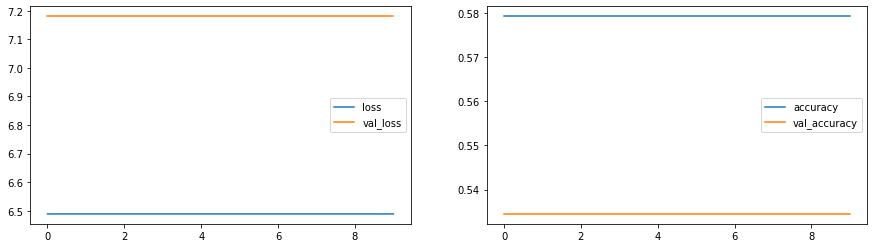

In [38]:
plot(fit_model_first)

## Get embeddings for each word (concatenate)

In [39]:
embeddings = []
for sentence in text:
    embedding = []
    for word in sentence.split():
        if word in glove:
            embedding.extend(glove.get_vector(word))
        else:
            embedding.extend(np.zeros(100).tolist())
    # pad extra zeros to make length of each embedding = 2200
    if len(embedding) < 2200:
        padding_len = 2200 - len(embedding)
        embedding.extend(np.zeros(padding_len).tolist())
    embedding = np.array(embedding)
    embeddings.append(embedding)
embeddings = np.array(embeddings)

In [40]:
X_train = embeddings[:7613]
X_test = embeddings[7613:] 
y_train = train['target'].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(7613, 2200)
(3263, 2200)
(7613,)


## Creating Model (Concatenated Embeddings Model)

In [41]:
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 10
val_split = 0.2

keras.backend.clear_session()
inputs = keras.Input(shape = (X_train.shape[1]))
x = layers.Dense(32, activation = act, input_dim = X_train.shape[1])(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation = act)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16, activation = act)(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Glove-FFN-Concatenated')

In [42]:
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
fit_model_second = model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/10
191/191 [==============================] - 2s 7ms/step - loss: 2.3954 - accuracy: 0.6394 - val_loss: 0.7141 - val_accuracy: 0.7459
Epoch 2/10
191/191 [==============================] - 1s 5ms/step - loss: 2.0488 - accuracy: 0.6741 - val_loss: 1.1061 - val_accuracy: 0.7571
Epoch 3/10
191/191 [==============================] - 1s 6ms/step - loss: 1.9107 - accuracy: 0.6716 - val_loss: 1.1145 - val_accuracy: 0.7676
Epoch 4/10
191/191 [==============================] - 1s 6ms/step - loss: 1.6058 - accuracy: 0.6874 - val_loss: 1.0539 - val_accuracy: 0.7328
Epoch 5/10
191/191 [==============================] - 1s 6ms/step - loss: 1.4721 - accuracy: 0.6962 - val_loss: 0.7687 - val_accuracy: 0.7761
Epoch 6/10
191/191 [==============================] - 1s 5ms/step - loss: 1.3753 - accuracy: 0.6929 - val_loss: 0.7344 - val_accuracy: 0.7702
Epoch 7/10
191/191 [==============================] - 1s 5ms/step - loss: 1.2724 - accuracy: 0.6962 - val_loss: 0.7434 - val_accuracy: 0.6533
Epoch 

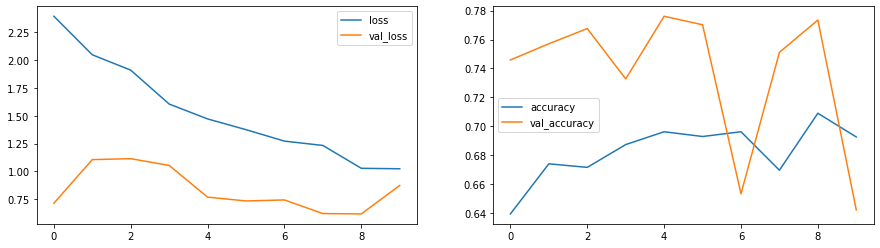

In [43]:
plot(fit_model_second)

## Creating Embeddings (for LSTM)
Understanding input sizes for using LSTM: https://stackoverflow.com/questions/50418973/how-lstm-work-with-word-embeddings-for-text-classification-example-in-keras

In [44]:
embeddings = []
for sentence in text:
    embedding = []
    for word in sentence.split():
        if word in glove:
            embedding.append(glove.get_vector(word).tolist())
        else:
            embedding.append(np.zeros(embedding_length).tolist())
    # pad extra zeros to make length of each sentence = 22 
    while len(embedding) < 22:
        embedding.append(np.zeros(embedding_length).tolist())
    embeddings.append(embedding)
embeddings = np.array(embeddings)
print(embeddings.shape)

(10876, 22, 100)


In [45]:
X_train = embeddings[:7613]
X_test = embeddings[7613:]
y_train = train['target'].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(7613, 22, 100)
(3263, 22, 100)
(7613,)


## Creating and training LSTM model
(Using only the text feature)

In [46]:
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 10
val_split = 0.2

keras.backend.clear_session()
inputs = keras.Input(shape = (22, embedding_length))
x = layers.LSTM(64)(inputs)
x = layers.Dense(32, activation = act)(x)
x = layers.Dense(16, activation = act)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Glove-LSTM')

In [47]:
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
fit_model_third = model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/10
191/191 [==============================] - 6s 14ms/step - loss: 0.6205 - accuracy: 0.6966 - val_loss: 0.6378 - val_accuracy: 0.6362
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.5055 - accuracy: 0.7645 - val_loss: 0.4197 - val_accuracy: 0.8168
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4975 - accuracy: 0.7750 - val_loss: 0.4838 - val_accuracy: 0.7978
Epoch 4/10
191/191 [==============================] - 2s 11ms/step - loss: 0.4630 - accuracy: 0.7993 - val_loss: 0.4197 - val_accuracy: 0.8221
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.6407 - accuracy: 0.6662 - val_loss: 0.6564 - val_accuracy: 0.6225
Epoch 6/10
191/191 [==============================] - 2s 11ms/step - loss: 0.5845 - accuracy: 0.6931 - val_loss: 0.4432 - val_accuracy: 0.8030
Epoch 7/10
191/191 [==============================] - 2s 11ms/step - loss: 0.4571 - accuracy: 0.7975 - val_loss: 0.4414 - val_accuracy: 0.8096

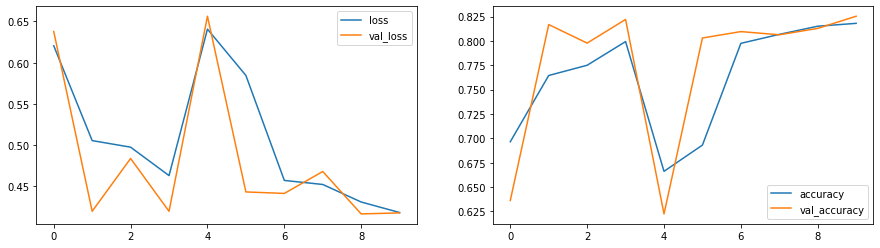

In [48]:
plot(fit_model_third)

## Creating and training GRU model

In [49]:
act = 'tanh'
batch_len = 16
opt = 'adam'
epoch = 10
val_split = 0.2

keras.backend.clear_session()
inputs = keras.Input(shape = (22, embedding_length))
x = layers.GRU(64)(inputs)
x = layers.Dense(32, activation = act)(x)
x = layers.Dense(16, activation = act)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'Glove-GRU')

In [50]:
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
fit_model_fourth = model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/10
381/381 [==============================] - 6s 11ms/step - loss: 0.6699 - accuracy: 0.7013 - val_loss: 0.4873 - val_accuracy: 0.7997
Epoch 2/10
381/381 [==============================] - 4s 10ms/step - loss: 0.5940 - accuracy: 0.7286 - val_loss: 0.5466 - val_accuracy: 0.7551
Epoch 3/10
381/381 [==============================] - 4s 9ms/step - loss: 0.5187 - accuracy: 0.7719 - val_loss: 0.5018 - val_accuracy: 0.8148
Epoch 4/10
381/381 [==============================] - 4s 10ms/step - loss: 0.4958 - accuracy: 0.8051 - val_loss: 0.6306 - val_accuracy: 0.8142
Epoch 5/10
381/381 [==============================] - 4s 10ms/step - loss: 0.4458 - accuracy: 0.8125 - val_loss: 0.4771 - val_accuracy: 0.8188
Epoch 6/10
381/381 [==============================] - 4s 10ms/step - loss: 0.4210 - accuracy: 0.8217 - val_loss: 0.4821 - val_accuracy: 0.8240
Epoch 7/10
381/381 [==============================] - 4s 10ms/step - loss: 0.4513 - accuracy: 0.8031 - val_loss: 0.6400 - val_accuracy: 0.8089


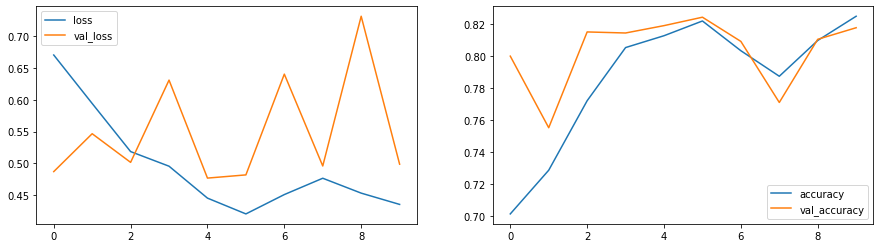

In [51]:
plot(fit_model_fourth)

## LSTM model with self-attention

In [52]:
act = 'tanh'
batch_len = 16
opt = 'adam'
epoch = 10
val_split = 0.2

keras.backend.clear_session()
inputs = keras.Input(shape = (22, embedding_length))
x = layers.GRU(64, return_sequences = True)(inputs)
x = SeqSelfAttention(attention_activation = 'tanh')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(32, activation = act)(x)
x = layers.Dense(16, activation = act)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs = inputs, outputs = outputs, name = 'GRU-self-attention')

In [53]:
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
fit_model_fifth = model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/10
381/381 [==============================] - 8s 13ms/step - loss: 0.5583 - accuracy: 0.7493 - val_loss: 0.4339 - val_accuracy: 0.8135
Epoch 2/10
381/381 [==============================] - 4s 11ms/step - loss: 0.4945 - accuracy: 0.7901 - val_loss: 0.4732 - val_accuracy: 0.8030
Epoch 3/10
381/381 [==============================] - 4s 11ms/step - loss: 0.4649 - accuracy: 0.8020 - val_loss: 0.4604 - val_accuracy: 0.8076
Epoch 4/10
381/381 [==============================] - 4s 11ms/step - loss: 0.4512 - accuracy: 0.8064 - val_loss: 0.4364 - val_accuracy: 0.8129
Epoch 5/10
381/381 [==============================] - 4s 12ms/step - loss: 0.5059 - accuracy: 0.7870 - val_loss: 0.4880 - val_accuracy: 0.7978
Epoch 6/10
381/381 [==============================] - 4s 12ms/step - loss: 0.4504 - accuracy: 0.8059 - val_loss: 0.4591 - val_accuracy: 0.8096
Epoch 7/10
381/381 [==============================] - 4s 11ms/step - loss: 0.4649 - accuracy: 0.7979 - val_loss: 0.4731 - val_accuracy: 0.8011

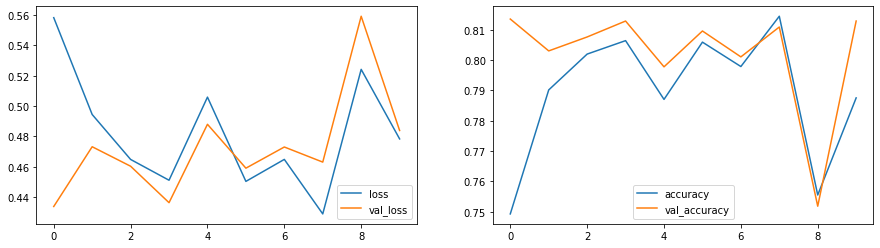

In [54]:
plot(fit_model_fifth)

## Preparing "keyword" feature

1.  Training data "keywords" processing
2.  Replacing keywords with embeddings

In [55]:
train['keyword'].unique()

keywords = train['keyword'].fillna('none').replace('%20', ' ', regex = True).tolist()

keyword_embeddings = []
for keyword in keywords:
    embedding = np.zeros(embedding_length)
    word_count = 0
    for word in keyword.split():
        if word in glove: 
            embedding += glove.get_vector(word)
            word_count += 1
    if word_count != 0:
        embedding /= word_count
    keyword_embeddings.append(embedding)

keyword_embeddings_train = np.array(keyword_embeddings)

# replace "%20" with " "
keywords = test['keyword'].fillna('none').replace('%20', ' ', regex = True).tolist()

keyword_embeddings = []
for keyword in keywords:
    embedding = np.zeros(embedding_length)
    word_count = 0
    for word in keyword.split():
        if word in glove: 
            embedding += glove.get_vector(word)
            word_count += 1
    if word_count != 0:
        embedding /= word_count
    keyword_embeddings.append(embedding)

keyword_embeddings_test = np.array(keyword_embeddings)

In [56]:
print(keyword_embeddings_train.shape)
print(keyword_embeddings_test.shape)

(7613, 100)
(3263, 100)


## Preparing "location" feature

In [57]:
print(train['location'].nunique())
train['location'].unique()


locations = train['location'].fillna('none').replace('[^a-zA-Z ]', ' ', regex = True).tolist()

location_embeddings = []
for location in locations:
    embedding = np.zeros(embedding_length)
    word_count = 0
    for word in location.split():
        if word in glove: 
            embedding += glove.get_vector(word)
            word_count += 1
    if word_count != 0:
        embedding /= word_count
    location_embeddings.append(embedding)

location_embeddings_train = np.array(location_embeddings)

locations = test['location'].fillna('none').replace('[^a-zA-Z ]', ' ', regex = True).tolist()

location_embeddings = []
for location in locations:
    embedding = np.zeros(embedding_length)
    word_count = 0
    for word in location.split():
        if word in glove: 
            embedding += glove.get_vector(word)
            word_count += 1
    if word_count != 0:
        embedding /= word_count
    location_embeddings.append(embedding)

location_embeddings_test = np.array(location_embeddings)

3341


In [58]:
print(location_embeddings_train.shape)
print(location_embeddings_test.shape)

(7613, 100)
(3263, 100)


In [59]:
# concatenate "keyword" and location features
non_sequential_train = np.concatenate((keyword_embeddings_train, location_embeddings_train), axis = 1)
non_sequential_test = np.concatenate((keyword_embeddings_test, location_embeddings_test), axis = 1)
print(non_sequential_train.shape)
print(non_sequential_test.shape)

(7613, 200)
(3263, 200)


## Non-linear LSTM model (with both seq and non-seq inputs)

In [60]:
act = 'tanh'
batch_len = 16
opt = 'adam'
epoch = 20
val_split = 0.2

keras.backend.clear_session()
seq_input = keras.Input(shape = (22, embedding_length))
non_seq_input = keras.Input(shape = (2 * embedding_length))
x = layers.GRU(64, return_sequences = True)(seq_input)
x = SeqSelfAttention(attention_activation = 'tanh')(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.concatenate([x, non_seq_input])
x = layers.Dense(64, activation = act)(x)
x = layers.Dense(16, activation = act)(x)
output = layers.Dense(1)(x)
model = keras.Model(inputs = [seq_input, non_seq_input], outputs = output, name = 'complete_model')

model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
fit_model_sixth = model.fit([X_train, non_sequential_train], y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/20
381/381 [==============================] - 8s 13ms/step - loss: 1.8258 - accuracy: 0.6404 - val_loss: 0.7838 - val_accuracy: 0.6986
Epoch 2/20
381/381 [==============================] - 4s 11ms/step - loss: 0.7123 - accuracy: 0.7466 - val_loss: 0.6879 - val_accuracy: 0.7039
Epoch 3/20
381/381 [==============================] - 5s 12ms/step - loss: 0.5774 - accuracy: 0.7535 - val_loss: 0.5591 - val_accuracy: 0.6980
Epoch 4/20
381/381 [==============================] - 4s 11ms/step - loss: 0.5332 - accuracy: 0.7680 - val_loss: 0.4561 - val_accuracy: 0.8102
Epoch 5/20
381/381 [==============================] - 5s 12ms/step - loss: 0.4700 - accuracy: 0.8051 - val_loss: 0.4520 - val_accuracy: 0.8063
Epoch 6/20
381/381 [==============================] - 4s 12ms/step - loss: 0.4508 - accuracy: 0.8056 - val_loss: 0.4574 - val_accuracy: 0.8201
Epoch 7/20
381/381 [==============================] - 4s 12ms/step - loss: 0.4580 - accuracy: 0.8011 - val_loss: 0.5472 - val_accuracy: 0.7334

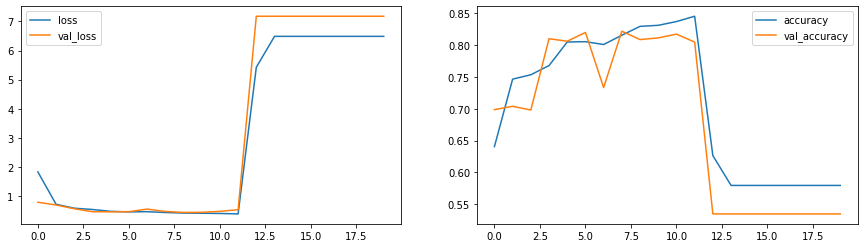

In [61]:
plot(fit_model_sixth)

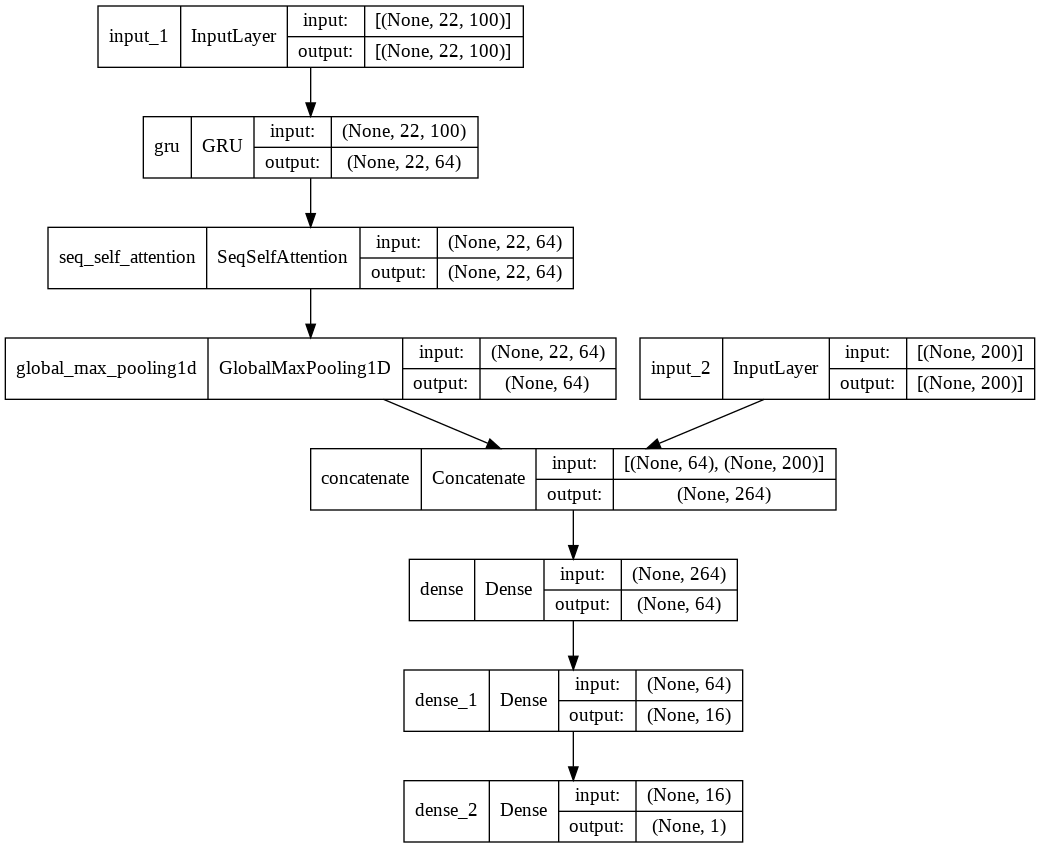

In [62]:
tf.keras.utils.plot_model(model, show_shapes = True)

## Geting results for test set and generating CSV

In [63]:
y_test = model.predict([X_test, non_sequential_test])
y_pred = []
for i in range(len(y_test)):
    if y_test[i][0] > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
test['target'] = y_pred
final = test[['target']]
final.to_csv('pred.csv', index = False)
final

y_test_norm = y_test.astype("int64")

In [64]:
print('null accuracy:', max(sum(y_test_norm)/y_test_norm.shape[0],1-sum(y_test)/y_test.shape[0]))
print("Accuracy: %.2f%%" % (accuracy_score(y_test_norm, y_pred)*100))
print(classification_report(y_test_norm, y_pred))
pd.DataFrame(confusion_matrix(y_test_norm, y_pred))

null accuracy: [1.4854839]
Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3263

    accuracy                           1.00      3263
   macro avg       1.00      1.00      1.00      3263
weighted avg       1.00      1.00      1.00      3263



,0
0,3263


# 2. BERT

1. Create features for BERT
2. Build the model in Keras
3. Model tuning and cross validation
4. Make prediction for test set

In [65]:
!pip install tqdm
!pip install transformers

In [66]:
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [67]:
from sklearn.model_selection import train_test_split

## Models for BERT 

In [79]:
train_X, val_X, train_Y, val_Y = train_test_split(train['text'], train['target'], test_size=0.15, random_state=42)
train_X, val_X, train_Y, val_Y = train_X.values, val_X.values, train_Y.values, val_Y.values
test_X = test['text'].values

In [80]:
import tqdm

def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [81]:
MAX_SEQ_LENGTH = 200

train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_X, 
                                                                      max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, val_X, 
                                                                  max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Converting docs to features: 100%|██████████| 1142/1142 [00:00<00:00, 1361.26it/s]

Train Features: (6471, 200) (6471, 200)
Val Features: (1142, 200) (1142, 200)


In [82]:
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_X, 
                                                                    max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 3263/3263 [00:02<00:00, 1318.28it/s]


Test Features: (3263, 200) (3263, 200)


## Defining model

In [83]:
inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    
dense1 = tf.keras.layers.Dense(64, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.3)(dense1)
dense2 = tf.keras.layers.Dense(16, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.3)(dense2)
output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-6, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.AUC()])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Fit and tuning

In [87]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

fit_bert_model = model.fit([train_features_ids, 
           train_features_masks], train_Y, 
          validation_data=([val_features_ids, 
                            val_features_masks], val_Y),
          epochs=5, 
          batch_size=20, 
          shuffle=True,
          callbacks=[es],
          verbose=1)

predictions = [1 if pr > 0.5 else 0 
                   for pr in model.predict([val_features_ids, 
                                            val_features_masks], batch_size=200, verbose=0).ravel()]

Epoch 1/5
324/324 [==============================] - 273s 844ms/step - loss: 0.4809 - accuracy: 0.7935 - auc_2: 0.8454 - val_loss: 0.4286 - val_accuracy: 0.8275 - val_auc_2: 0.8671
Epoch 2/5
324/324 [==============================] - 274s 845ms/step - loss: 0.4392 - accuracy: 0.8197 - auc_2: 0.8692 - val_loss: 0.4215 - val_accuracy: 0.8196 - val_auc_2: 0.8761
Epoch 3/5
324/324 [==============================] - 274s 846ms/step - loss: 0.4182 - accuracy: 0.8311 - auc_2: 0.8837 - val_loss: 0.4117 - val_accuracy: 0.8284 - val_auc_2: 0.8784
Epoch 4/5
324/324 [==============================] - 273s 844ms/step - loss: 0.3895 - accuracy: 0.8456 - auc_2: 0.8984 - val_loss: 0.4117 - val_accuracy: 0.8327 - val_auc_2: 0.8784
Epoch 5/5
324/324 [==============================] - 273s 842ms/step - loss: 0.3660 - accuracy: 0.8550 - auc_2: 0.9101 - val_loss: 0.4159 - val_accuracy: 0.8345 - val_auc_2: 0.8757
Epoch 00005: early stopping


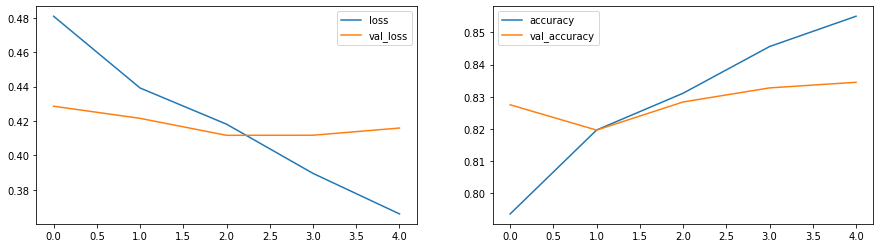

In [89]:
plot(fit_bert_model)

In [90]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
print('null accuracy:', max(sum(val_Y)/val_Y.shape[0],1-sum(val_Y)/val_Y.shape[0]))
print("Accuracy: %.2f%%" % (accuracy_score(val_Y, predictions)*100))
print("roc auc:", roc_auc_score(val_Y, predictions))
print(classification_report(val_Y, predictions))
pd.DataFrame(confusion_matrix(val_Y, predictions))

null accuracy: 0.5700525394045535
Accuracy: 82.84%
roc auc: 0.8219314793784277
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       651
           1       0.82      0.78      0.80       491

    accuracy                           0.83      1142
   macro avg       0.83      0.82      0.82      1142
weighted avg       0.83      0.83      0.83      1142



,0,1
0,565,86
1,110,381


## Predicting test set

In [91]:
test_Y=model.predict([test_features_ids, test_features_masks], batch_size=200, verbose=0)

test_label=[]

for i in range(test_Y.shape[0]):
    if test_Y[i]>=0.5:
        test_label.append(1)
    else:
        test_label.append(0)

## Getting results for test set 

In [94]:
submission = pd.DataFrame({'target':test_label})
print(submission.head(10))

filename = 'submission_nlp_tweets_bert.csv'

submission.to_csv(filename,index=False)

   target
0       1
1       1
2       1
3       1
4       1
5       1
6       0
7       0
8       0
9       0
